In [1]:
from download_day import download_day
from load_saved_fd4 import load_saved_fd4
from scrape_aircraft_list import scrape_aircraft_list
from get_perf_model_typecodes import get_perf_model_typecodes 
from match_icao_model import match_icao_model
from process_airport_list import process_airport_list
from generate_flightpath import generate_flightpath
from plot_flightpaths import plot_flightpaths
from get_engine_data import get_engine_data
from perf_model_powerplant_parser import perf_model_powerplant_parser
from match_engine_to_emissions_db import match_engine_to_emissions_db
from process_month_emissions import process_month_emissions
from get_era5_wind import get_era5_wind
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tqdm
from time import sleep
from geopy import distance
import requests
from icet import icet
from bffm2 import bffm2

%matplotlib inline

# User Inputs:
start_time_str       = '2023-01-01T00:00:00Z'
stop_time_str        = '2023-12-31T23:59:59Z'
query_limit          = 15e4
send_notification    = True
make_plot            = True
output_dir           = "/scratch/omg28/Data/"

# Convert start and stop times to datetime objects
start_time_simple = pd.to_datetime(start_time_str).strftime("%Y-%m-%d")
stop_time_simple = pd.to_datetime(stop_time_str).strftime("%Y-%m-%d")
analysis_year = pd.to_datetime(start_time_str).year

# Section 1. Download flight information from Opensky

In [9]:

# Download data from OpenSky history database
# WARNING: This may take a long time to run and will use a lot of disk space. Recommend running this in a .py script to avoid recurring memory issues found in Jupyter notebooks.
# download_day(start_time_str, stop_time_str, query_limit, send_notification, make_plot, output_dir)


# Section 2. Scrape the EUCONTROL database for aircraft flight performance information

In [ ]:
"""
# scrape the list of aircraft with performance models from the EUCONTROL website
perf_model_typecodes = get_perf_model_typecodes()
## WARNING: THIS CAN GET YOUR IP ADDRESS BLOCKED IF YOU RUN IT REPEATEDLY. IT IS A WEB SCRAPER.
aircraft_list = scrape_aircraft_list(perf_model_typecodes)

"""

Saved typecodes_available to /scratch/omg28/Data/aircraftdb/performance_models_typecodes.csv


In [ ]:
'''
# get the aircraft metadata database from the OpenSky network
os.system(f'wget -P {output_dir}aircraftdb https://s3.opensky-network.org/data-samples/metadata/aircraft-database-complete-2025-02.csv')

# get airport list from the ourairports database
os.system(f'wget -P {output_dir}airportdb https://davidmegginson.github.io/ourairports-data/airports.csv')

# Download the ICAO engine database from easa database and save it as a CSV file
xlsx_url = "https://www.easa.europa.eu/en/downloads/131424/en"
xlsx_path = "/scratch/omg28/Data/engine_data/engine_data_icao.xlsx"
csv_path = "/scratch/omg28/Data/engine_data/engine_data_icao.csv"

# Download the file if it doesn't exist
if not os.path.exists(xlsx_path):
    os.makedirs(os.path.dirname(xlsx_path), exist_ok=True)
    r = requests.get(xlsx_url)
    with open(xlsx_path, 'wb') as f:
        f.write(r.content)

# Read the specified sheet and save as CSV
df = pd.read_excel(xlsx_path, sheet_name='Gaseous Emissions and Smoke')
df.to_csv(csv_path, index=False)

# Get ERA5 wind reanalysis data for the specified time period
netcdf_path = get_era5_wind(analysis_year, output_dir)
'''

2025-05-26 15:06:52,103 WARNING [2025-05-26T00:00:00] Service may suffer disruptions. Please check [here](https://status.ecmwf.int/) for status updates.
2025-05-26 15:06:52,104 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-26 15:06:52,104 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-26 15:06:52,495 INFO Request ID is c83101ec-66ef-4e93-b7c1-e041c8ec536e
2025-05-26 15:06:52,584 INFO status has been updated to accepted
2025-05-26 15:07:16,239 INFO status has been updated to successful


6a88fad706e66bd717f287be00ffaf75.nc:   0%|          | 0.00/177M [00:00<?, ?B/s]

In [5]:
# remove the helicopters from the aircraft performance database list
perf_models = pd.read_csv("aircraft_performance_table.csv")
perf_models = perf_models[~perf_models['type'].str.contains('H')]
perf_models.to_csv("aircraft_performance_table_filtered.csv", index=False)
pd.to_pickle(perf_models, "aircraft_performance_table_filtered.pkl")


# Section 3. Process the aircraft performance and flight data, retaining only flights we have takeoff, landing, plane type, and aircraft performance model information about. Further, drop all flights with aircraft codes that do not correspond to a code in the ourairports registry.

In [9]:
# process the loaded time period of data. - 26s

# - matches 24 bit transponder codes from Feb 2025 aircraft metadata database with the ICAO typecode

# - removes all flights for which the transponder code does not have a corresponding ICAO typecode



# - removes all flights for which the takeoff OR landing airport is unknown

for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    # Set end date to last day of month at 23:59:59 UTC
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    print(f"Processing data from {start_time_str_loop} to {stop_time_str_loop}")

    flights_with_typecode = match_icao_model(str(start_time_str_loop), str(stop_time_str_loop), query_limit, 
                                            aircraft_db_path = "/scratch/omg28/Data/aircraftdb/aircraft-database-complete-2025-02.csv",
                                            flight_db_path = "/scratch/omg28/Data/no_track2023/",
                                            output_dir = "/scratch/omg28/Data/aircraftdb/")

    # Load in the list of ICAO typecodes that have a performance model - 7.5s
    performance_model_typecodes = pd.read_pickle('/scratch/omg28/Data/aircraftdb/performance_models_typecodes.pkl')

    # load in the list of all flights with typecode and takeoff/landing airport - uncomment this line to load the data from a .pkl file
    # instead of running the match_icao_model function
    # flights_with_typecode = pd.read_pickle(f'/scratch/omg28/Data/aircraftdb/{start_time_simple_loop}_to_{stop_time_simple_loop}_{int(query_limit)}_typecodes_added.pkl')

    # get info before the merge
    print("Before merging:")
    print(flights_with_typecode.info())

    # inner join the loaded year of data with the scraped aircraft list
    # - this will remove all flights for which the ICAO typecode does not have a corresponding performance model
    flights_with_perf_typecode = pd.merge(flights_with_typecode, performance_model_typecodes, how='inner', on = 'typecode')

    print("After merging:")
    print(flights_with_perf_typecode.info())

    # print a list of typecodes in complete_flights_perf_model that do not have a performance model
    missing_perf_models = flights_with_typecode[~flights_with_typecode['typecode'].isin(performance_model_typecodes['typecode'])]
    print("Aircraft models with observed flights, but no performance model: " + str(len(missing_perf_models['typecode'].unique())))
    print("total flights in 2024 with TOLD and typecode, but no performance model: " + str(len(missing_perf_models)))

    # print a list of typecodes in performance_model_typecodes that do not correspond to a flight
    missing_flights = performance_model_typecodes[~performance_model_typecodes['typecode'].isin(flights_with_typecode['typecode'])]
    print("Number of performance models with no flights: " + str(len(missing_flights['typecode'].unique())))
    print("Number of flights with TOLD, typecode, and performance model: " + str(len(flights_with_perf_typecode)))

    # count all flights starting and ending at the same airport
    num_flights_no_dist = len(flights_with_perf_typecode[flights_with_perf_typecode['estdepartureairport'] == flights_with_perf_typecode['estarrivalairport']])
    print("Number of flights with no distance: " + str(num_flights_no_dist))

    # remove all flights starting or ending at the same airport
    flights_with_perf_typecode_dist = flights_with_perf_typecode[flights_with_perf_typecode['estdepartureairport'] != flights_with_perf_typecode['estarrivalairport']]
    print("Number of flights with TOLD, typecode, performance model, and nonzero distance: " + str(len(flights_with_perf_typecode_dist)))

    # load the takeoff and landing airport location information to the dataframe. 18s
    all_airports = process_airport_list()

    # add the estimated departure airport location information to the dataframe
    # - this will remove all flights for which the departure airport is unknown
    flights_with_perf_typecode_dist_dep = pd.merge(flights_with_perf_typecode_dist, all_airports, how='inner', left_on = 'estdepartureairport', right_on = 'ident')
    flights_with_perf_typecode_dist_dep.rename(columns = {'latitude_deg': 'estdeparturelat', 'longitude_deg': 'estdeparturelong', 'elevation_ft': 'estdeparturealt_ft'}, inplace=True)
    flights_with_perf_typecode_dist_dep.drop(columns = ['ident', 'gps_code'], inplace=True)

    # count the number of flights with no departure airport in the database
    print("Number of flights with no departure airport location info in database: " + str(len(flights_with_perf_typecode_dist) - len(flights_with_perf_typecode_dist_dep)))

    # add the estimated arrival airport location information to the dataframe
    all_flights_filtered = pd.merge(flights_with_perf_typecode_dist_dep, all_airports, how='inner', left_on = 'estarrivalairport', right_on = 'ident')
    all_flights_filtered.rename(columns = {'latitude_deg': 'estarrivallat', 'longitude_deg': 'estarrivallong', 'elevation_ft': 'estarrivalalt_ft'}, inplace=True)
    all_flights_filtered.drop(columns = ['ident', 'gps_code', 'id_x', 'id_y'], inplace=True)
    
    # save the result to a pickle file
    output_dir = os.path.expanduser(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f"aircraftdb/{start_time_simple_loop}_to_{stop_time_simple_loop}_{int(query_limit)}_typecodes_airports_added.pkl")
    all_flights_filtered.to_pickle(filename)

    # count the number of flights with no arrival airport in the database
    print("Number of flights with no arrival airport location info in database: " + str(len(flights_with_perf_typecode_dist_dep) - len(all_flights_filtered)))
    print("Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info: " + str(len(all_flights_filtered)))


Processing data from 2023-01-01 00:00:00+00:00 to 2023-01-31 23:59:59+00:00
There are 3183 unique typecodes in the aircraft database.
Saved result_df to /scratch/omg28/Data/aircraftdb/2023-01-01_to_2023-01-31_150000_typecodes_added.pkl
Before merging:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578257 entries, 0 to 1578256
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype          
---  ------               --------------    -----          
 0   icao24               1578257 non-null  object         
 1   estdepartureairport  1578257 non-null  string[pyarrow]
 2   estarrivalairport    1578257 non-null  string[pyarrow]
 3   day                  1578257 non-null  int64[pyarrow] 
 4   typecode             1578114 non-null  object         
dtypes: int64[pyarrow](1), object(2), string[pyarrow](2)
memory usage: 60.6+ MB
None
After merging:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337395 entries, 0 to 1337394
Data columns (total 5 columns):
 #  

/home/owgraham/ConflictTrails/ConflictTrails/match_icao_model.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flight_df = pd.concat([flight_df, load_saved_fd4(current_day, flight_db_path, query_limit)], axis=0, ignore_index=True)
/home/owgraham/ConflictTrails/ConflictTrails/match_icao_model.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flight_df = pd.concat([flight_df, load_saved_fd4(current_day, flight_db_path, query_limit)], axis=0, ignore_index=True)
/home/owgraham/ConflictTrails/

Saved result_df to /scratch/omg28/Data/aircraftdb/2023-12-01_to_2023-12-31_150000_typecodes_added.pkl
Before merging:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671601 entries, 0 to 1671600
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype          
---  ------               --------------    -----          
 0   icao24               1671601 non-null  object         
 1   estdepartureairport  1671601 non-null  string[pyarrow]
 2   estarrivalairport    1671601 non-null  string[pyarrow]
 3   day                  1671601 non-null  int64[pyarrow] 
 4   typecode             1671526 non-null  object         
dtypes: int64[pyarrow](1), object(2), string[pyarrow](2)
memory usage: 64.2+ MB
None
After merging:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1410432 entries, 0 to 1410431
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype          
---  ------               --------------    -----          
 0   icao24       

# Section 4. Using the great circle distance, calculate the distance between the airport takeoff and landing.

In [10]:
# calculate the great circle distance between the departure and arrival airports - 5.5 min

# Ensure max_distances_all is defined before the loop
max_distances_all = pd.DataFrame(columns=['typecode', 'max_distance_km'])

for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    # Set end date to last day of month at 23:59:59 UTC
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    # calculare great circle distance between the departure and arrival airports
    all_flights_filtered = pd.read_pickle(f'/scratch/omg28/Data/aircraftdb/{start_time_simple_loop}_to_{stop_time_simple_loop}_{int(query_limit)}_typecodes_airports_added.pkl')
    all_flights_filtered['gc_km'] = all_flights_filtered.apply(lambda x: distance.great_circle((x['estdeparturelat'], x['estdeparturelong']), (x['estarrivallat'], x['estarrivallong'])).km, axis=1)
    
    # could be sped up by using a vectorized function - 1 min
    # adjust great circle distance using eq. 6 of seymour, et al (2020)
    all_flights_filtered['gc_FEAT_km'] = all_flights_filtered.apply(lambda x: 1.0387 * x['gc_km'] + 40.5, axis = 1)
    pd.to_pickle(all_flights_filtered, f'{output_dir}/{start_time_simple_loop}_to_{stop_time_simple_loop}_filtered.pkl')
    
    # remove all flights under 200 km:
    all_flights_filtered = all_flights_filtered[all_flights_filtered['gc_FEAT_km'] > 200]
    print("Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: " + str(len(all_flights_filtered)))

    # update max_distances across all months
    if max_distances_all.empty:
        max_distances_all = all_flights_filtered.groupby('typecode')['gc_FEAT_km'].max().reset_index()
        max_distances_all.columns = ['typecode', 'max_distance_km']
    else:
        max_distances_month = all_flights_filtered.groupby('typecode')['gc_FEAT_km'].max().reset_index()
        max_distances_month.columns = ['typecode', 'max_distance_km']
        # merge and keep the maximum for each typecode
        max_distances_all = pd.concat([max_distances_all, max_distances_month]).groupby('typecode', as_index=False)['max_distance_km'].max()

    # save the merged dataframe to a .pkl file - 15s
    all_flights_filtered.to_pickle(f'{output_dir}/aircraftdb/{start_time_simple}_to_{stop_time_simple}_filtered.pkl')
    # save the max distances dataframe to a .csv file
    max_distances_all.to_csv(f'{output_dir}/aircraftdb/{start_time_simple}_to_{stop_time_simple}_typecode_max_distances.csv', index=False)


Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: 977854
Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: 999752
Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: 1192328
Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: 1200142
Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: 1292872
Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: 1274320
Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: 1295772
Number of flights with TOLD, typecode, performance model, distance, and departure/arrival airport info over 200 km: 1371660
Number of 

# Section 5: parse the engine data and emissions data and add it to the aircraft performance model.

In [11]:
# Loads data from the saved engine data .csv files for analysis. Saves this dataframe to a .pkl file
# Setting "remove_superseded" to True will remove all engines that are superseded by an updated emissions model
engine_models = get_engine_data(update_superseded=False)
engine_models_removed = get_engine_data(update_superseded=True)
# calculate how many engines were removed
print("Number of engines that would be removed: " + str(len(engine_models['Engine Identification'].unique()) - len(engine_models_removed['Engine Identification'].unique())))
# print the list of the engine models that are in engine_models_kept but not in engine_models_removed
superseded_not_replaced = engine_models[~engine_models['Engine Identification'].isin(engine_models_removed['Engine Identification'])].get('Engine Identification').unique()
print("List of engines that were removed: " + str(superseded_not_replaced))
# POTENTIAL FIX: REMOVE ENGINES THAT HAVE BEEN SUPERSEDED BY AN UPDATED EMISSIONS MODE


Data loaded from /scratch/omg28/Data/engine_data/engine_data_icao.csv and saved to /scratch/omg28/Data/engine_data/engine_data_icao.pkl
Data loaded from /scratch/omg28/Data/engine_data/engine_data_icao.csv and saved to /scratch/omg28/Data/engine_data/engine_data_icao.pkl
Number of engines that would be removed: 21
List of engines that were removed: ['AE3007A1 series' 'LEAP-1B28' 'LEAP-1B28B2' 'LEAP-1B28/28B2/28B1/28B3'
 'CF34-10A16' 'CF34-3B' 'AS907-1-1A' 'HTF7250G (AS907-2-1G)'
 'HTF7350 (AS907-2-1A)' 'HTF7500E (AS907-3-1E-A1)'
 'HTF7500E (AS907-3-1E-A2)' 'HTF7500E (AS907-3-1E-A3)'
 'HTF7700L (AS907-2-1S)' 'PW308C' 'PW4x60' 'Trent 1000-A' 'Trent 1000-C'
 'Trent 1000-D' 'Trent 1000-E' 'Trent 1000-G' 'Trent 1000-H']


In [12]:
# loads the aircraft performance model data from the saved .csv file
performance_models = pd.read_csv("aircraft_performance_table_filtered.csv")

In [13]:
# extracts the powerplant data from the performance model dataframe and appends it to new columns in the performance model dataframe
allowed_manufacturers = engine_models['Manufacturer'].unique().tolist()
performance_models = perf_model_powerplant_parser(performance_models, coerce_manufacturer=True, allowed_manufacturers=allowed_manufacturers)


In [14]:
# 12s - attempts to match the powerplants extracted from the EUCONTROL aircraft performance model with an engine model in the engine emissions database
# reset the index of engine_models so that 'UID No' becomes a column rather than the index, otherwise the merge will not work
engine_models.reset_index(inplace=True)
# attempts to match the powerplants extracted from the EUCONTROL aircraft performance model with an engine model in the engine emissions database
performance_models_matched = match_engine_to_emissions_db(performance_models, engine_models)

In [15]:
# from all rows without a matched engine model
performance_models_matched = performance_models_matched.dropna(subset=['matched_engine_id'])

In [16]:
# print number of performance models whose engines match superseded engines
print("Number of performance models with engines that are superseded: " + str(len(performance_models_matched[performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)])))
print("Number of performance models with engines that are NOT superseded: " + str(len(performance_models_matched[~performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)])))
print("aircraft performance models with engines that are superseded: \n" + str(performance_models_matched[performance_models_matched['matched_engine_id'].isin(superseded_not_replaced)].get('typecode')))

Number of performance models with engines that are superseded: 10
Number of performance models with engines that are NOT superseded: 209
aircraft performance models with engines that are superseded: 
23     A388
61     B37M
62     B38M
63     B39M
64     B3XM
100    B788
101    B789
169    CL35
175    CRJ2
243    G280
Name: typecode, dtype: object


In [17]:
# Join the aircraft performance model data with the engine emissions database data
performance_and_emissions_model = pd.merge(performance_models_matched, engine_models, how='inner', left_on='matched_engine_uid_no', right_on='UID No')
pd.to_pickle(performance_and_emissions_model, "performance_and_emissions_model.pkl")

# Section 6: generate and visualize flightpath

In [12]:
# performance_data=pd.read_pickle('aircraft_performance_data_table.pkl')
performance_and_emissions_model = pd.read_pickle('performance_and_emissions_model.pkl')
aircraft_typecode = 'A320'
flightpath = generate_flightpath(aircraft_typecode, 500, performance_and_emissions_model)

In [ ]:
import matplotlib.pyplot as plt
# Sum durations from the flightpath dictionary for each phase
climb_time = (flightpath['climb'].get('t_climb_0_5', 0) +
              flightpath['climb'].get('t_climb_5_10', 0) +
              flightpath['climb'].get('t_climb_10_15', 0) +
              flightpath['climb'].get('t_climb_15_24', 0) +
              flightpath['climb'].get('t_climb_ceil', 0))

descent_time = (flightpath['descent'].get('t_descent_5_0', 0) +
                flightpath['descent'].get('t_descent_10_5', 0) +
                flightpath['descent'].get('t_descent_15_10', 0) +
                flightpath['descent'].get('t_descent_24_15', 0) +
                flightpath['descent'].get('t_descent_ceil', 0))

cruise_time = flightpath['cruise'].get('t_cruise', 0)

# Prepare data for the barchart
phases = ['Climb', 'Cruise', 'Descent']
durations = [climb_time, cruise_time, descent_time]

# Optionally convert seconds to minutes (or leave in seconds)
# durations = [t / 60.0 for t in durations]

plt.figure()
bars = plt.bar(phases, durations, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Flight Phases')
plt.ylabel('Duration (seconds)')
plt.title(f'Duration of Each Flight Leg ({aircraft_typecode})')

# Annotate bars with duration values
for bar, duration in zip(bars, durations):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{duration:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Break down the climb phases
climb_labels = ['Climb 0-5', 'Climb 5-10', 'Climb 10-15', 'Climb 15-24', 'Climb Ceil']
climb_times = [
    flightpath['climb'].get('t_climb_0_5', 0),
    flightpath['climb'].get('t_climb_5_10', 0),
    flightpath['climb'].get('t_climb_10_15', 0),
    flightpath['climb'].get('t_climb_15_24', 0),
    flightpath['climb'].get('t_climb_ceil', 0)
]

# Break down the descent phases
descent_labels = ['Descent 5-0', 'Descent 10-5', 'Descent 15-10', 'Descent 24-15', 'Descent Ceil']
descent_times = [
    flightpath['descent'].get('t_descent_5_0', 0),
    flightpath['descent'].get('t_descent_10_5', 0),
    flightpath['descent'].get('t_descent_15_10', 0),
    flightpath['descent'].get('t_descent_24_15', 0),
    flightpath['descent'].get('t_descent_ceil', 0)
]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Climb segments chart
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_labels, climb_times, color='skyblue')
plt.xlabel('Climb Segments')
plt.ylabel('Time (seconds)')
plt.title(f'Climb Phase Breakdown ({aircraft_typecode})')
for bar, t in zip(bars_climb, climb_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{t:.1f}', ha='center', va='bottom')

# Descent segments chart
plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_labels, descent_times, color='salmon')
plt.xlabel('Descent Segments')
plt.ylabel('Time (seconds)')
plt.title(f'Descent Phase Breakdown ({aircraft_typecode})')
for bar, t in zip(bars_descent, descent_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{t:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Overall phase distances (in meters)
climb_distance = (np.atleast_1d(flightpath['climb'].get('s_climb_0_5', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_5_10', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_10_15', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_15_24', 0))[0] +
                  np.atleast_1d(flightpath['climb'].get('s_climb_ceil', 0))[0])

cruise_distance = np.atleast_1d(flightpath['cruise'].get('s_cruise', 0))[0]

descent_distance = (np.atleast_1d(flightpath['descent'].get('s_descent_5_0', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_10_5', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_15_10', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_24_15', 0))[0] +
                    np.atleast_1d(flightpath['descent'].get('s_descent_ceil', 0))[0])

phases = ['Climb', 'Cruise', 'Descent']
distances = [climb_distance, cruise_distance, descent_distance]

plt.figure(figsize=(8, 6))
overall_bars = plt.bar(phases, distances, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Flight Phases')
plt.ylabel('Distance (meters)')
plt.title(f'Distance Covered in Each Flight Phase ({aircraft_typecode})')

# Annotate overall bars with distance values
for bar, dist in zip(overall_bars, distances):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{dist:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:


# Breakdown of distances for each segment

# For Climb Phase
climb_keys = ['s_climb_0_5', 's_climb_5_10', 's_climb_10_15', 's_climb_15_24', 's_climb_ceil']
climb_distances = []
for key in climb_keys:
    value = flightpath['climb'].get(key, np.array([0]))
    # value is expected to be a numpy array; extract its first element if so
    if isinstance(value, np.ndarray):
        climb_distances.append(value[0])
    else:
        climb_distances.append(value)

# For Descent Phase
descent_keys = ['s_descent_5_0', 's_descent_10_5', 's_descent_15_10', 's_descent_24_15', 's_descent_ceil']
descent_distances = []
for key in descent_keys:
    value = flightpath['descent'].get(key, np.array([0]))
    if isinstance(value, np.ndarray):
        descent_distances.append(value[0])
    else:
        descent_distances.append(value)

plt.figure(figsize=(14, 6))

# Climb segments chart
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_labels, climb_distances, color='skyblue')
plt.xlabel('Climb Segments')
plt.ylabel('Distance (meters)')
plt.title(f'Climb Phase Distance Breakdown ({aircraft_typecode})')
for bar, d in zip(bars_climb, climb_distances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{d:,.0f}', ha='center', va='bottom')

# Descent segments chart
plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_labels, descent_distances, color='salmon')
plt.xlabel('Descent Segments')
plt.ylabel('Distance (meters)')
plt.title(f'Descent Phase Distance Breakdown ({aircraft_typecode})')
for bar, d in zip(bars_descent, descent_distances):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{d:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Build cumulative distance and altitude lists.
# Starting at runway: (distance, altitude) = (0, 0)
distances_list = [0]
altitudes_list = [0]

# Climb phase:
# First climb segment (0-5):
cum_distance = distances_list[-1]
for key in flightpath:
    for key2 in flightpath[key]:
        if key2.startswith('s_'):
            cum_distance += flightpath[key][key2]
            distances_list.append(cum_distance)
            altitudes_list.append(flightpath[key][f'{key2.replace('s_', 'h_')}_end'])

# Plot the altitude profile vs. cumulative flight distance.
plt.figure(figsize=(10, 6))
plt.plot(distances_list, altitudes_list, marker='o', linestyle='-')
plt.xlabel('Cumulative Flight Distance (meters)')
plt.ylabel('Flight Altitude (meters)')
plt.title(f'Flight Altitude vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.show()

In [ ]:
# Generate 25 flight distances (km) with more samples at shorter distances using a non-linear (quadratic) spacing.
max_distances = pd.read_csv(f'/scratch/omg28/Data/no_track2024/{start_time_simple}_to_{stop_time_simple}_typecode_max_distances.csv')
max_distance_km = max_distances.loc[max_distances['typecode'] == aircraft_typecode, 'max_distance_km'].max()
num_flightpaths = 5

# Use quadratic spacing: more points at the start, fewer at the end
# Use logarithmic spacing: more points at the start, fewer at the end
flight_distances = np.logspace(np.log10(200), np.log10(1000), num_flightpaths)
flightpaths = [0] * num_flightpaths


for ii in range(num_flightpaths):
    d_km = flight_distances[ii]
    fp = generate_flightpath(aircraft_typecode, d_km, performance_and_emissions_model)
    flightpaths[ii] = fp

plot_flightpaths(flightpaths, aircraft_typecode)


In [ ]:

# Generate a grid of flight profiles varying both cruising altitude and total flight distance
max_cruise_altitude_ft = performance_and_emissions_model.loc[
    performance_and_emissions_model['typecode'] == aircraft_typecode, 'cruise_Ceiling'
].max() * 1e2

num_altitudes = 10
num_distances = 10
cruise_altitudes_ft = np.linspace(18000, max_cruise_altitude_ft, num_altitudes)
# Use quadratic spacing for grid as well
flight_distances_km = np.logspace(np.log10(200), np.log10(max_distance_km), num_distances)

flightpaths_grid = []
labels = []

for alt_ft in cruise_altitudes_ft:
    for d_km in flight_distances_km:
        fp = generate_flightpath(aircraft_typecode, d_km, performance_and_emissions_model, cruise_altitude_ft=alt_ft)
        flightpaths_grid.append(fp)
        labels.append(f"{int(alt_ft/1000)}kft, {int(d_km)}km")

# Example: plot total NOx emissions for each profile
total_nox = []
for fp in flightpaths_grid:
    nox = 0
    for k in ['NOx_climb_0_5', 'NOx_climb_5_10', 'NOx_climb_10_15', 'NOx_climb_15_24', 'NOx_climb_ceil']:
        nox += fp['climb'].get(k, 0)
    for k in ['NOx_descent_ceil', 'NOx_descent_24_15', 'NOx_descent_15_10', 'NOx_descent_10_5', 'NOx_descent_5_0']:
        nox += fp['descent'].get(k, 0)
    nox += fp.get('cruise', {}).get('NOx_cruise', 0)
    total_nox.append(nox)

plt.figure(figsize=(12, 6))
plt.bar(labels, total_nox, color='purple')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total NOx Emissions (g)')
plt.title(f'Total NOx Emissions for Various Altitudes and Distances ({aircraft_typecode})')
plt.tight_layout()
plt.show()

### Visualize NOx Emissions by Flight Phase

In [ ]:
# Visualize NOx emissions for each climb and descent phase
import matplotlib.pyplot as plt

climb_nox_labels = ['Climb 0-5', 'Climb 5-10', 'Climb 10-15', 'Climb 15-24', 'Climb Ceil']
climb_nox_keys = ['NOx_climb_0_5', 'NOx_climb_5_10', 'NOx_climb_10_15', 'NOx_climb_15_24', 'NOx_climb_ceil']
climb_nox_values = [flightpath['climb'].get(k, 0) for k in climb_nox_keys]

descent_nox_labels = ['Descent Ceil', 'Descent 24-15', 'Descent 15-10', 'Descent 10-5', 'Descent 5-0']
descent_nox_keys = ['NOx_descent_ceil', 'NOx_descent_24_15', 'NOx_descent_15_10', 'NOx_descent_10_5', 'NOx_descent_5_0']
descent_nox_values = [flightpath['descent'].get(k, 0) for k in descent_nox_keys]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
bars_climb = plt.bar(climb_nox_labels, climb_nox_values, color='deepskyblue')
plt.xlabel('Climb Segments')
plt.ylabel('NOx Emissions (g)')
plt.title(f'NOx Emissions During Climb ({aircraft_typecode})')
for bar, val in zip(bars_climb, climb_nox_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars_descent = plt.bar(descent_nox_labels, descent_nox_values, color='orange')
plt.xlabel('Descent Segments')
plt.ylabel('NOx Emissions (g)')
plt.title(f'NOx Emissions During Descent ({aircraft_typecode})')
for bar, val in zip(bars_descent, descent_nox_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Cumulative NOx Emissions vs. Flight Distance
num_flightpaths = 25
flight_distances = np.linspace(200, 5000, num_flightpaths)
cumulative_nox = []
for d_km in flight_distances:
    fp = generate_flightpath(aircraft_typecode, d_km, performance_and_emissions_model)
    total_nox = 0
    for k in ['NOx_climb_0_5', 'NOx_climb_5_10', 'NOx_climb_10_15', 'NOx_climb_15_24', 'NOx_climb_ceil']:
        total_nox += fp['climb'].get(k, 0)
    for k in ['NOx_descent_ceil', 'NOx_descent_24_15', 'NOx_descent_15_10', 'NOx_descent_10_5', 'NOx_descent_5_0']:
        total_nox += fp['descent'].get(k, 0)
    total_nox += fp.get('cruise', {}).get('NOx_cruise', 0)
    cumulative_nox.append(total_nox)

plt.figure(figsize=(8, 6))
plt.plot(flight_distances, cumulative_nox, marker='o', color='purple')
plt.xlabel('Flight Distance (km)')
plt.ylabel('Cumulative NOx Emissions (g)')
plt.title(f'Cumulative NOx Emissions vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Instantaneous NOx flux vs. flight distance
import numpy as np
import matplotlib.pyplot as plt

# Build lists for distance and NOx flux (g/s) at each segment
segment_distances = [0]
segment_nox_flux = []

# Climb segments
climb_keys = [
    ('s_climb_0_5', 't_climb_0_5', 'NOx_climb_0_5'),
    ('s_climb_5_10', 't_climb_5_10', 'NOx_climb_5_10'),
    ('s_climb_10_15', 't_climb_10_15', 'NOx_climb_10_15'),
    ('s_climb_15_24', 't_climb_15_24', 'NOx_climb_15_24'),
    ('s_climb_ceil', 't_climb_ceil', 'NOx_climb_ceil'),
]
cum_dist = 0
for s_key, t_key, nox_key in climb_keys:
    s = flightpath['climb'].get(s_key, 0)
    t = flightpath['climb'].get(t_key, 0)
    nox = flightpath['climb'].get(nox_key, 0)
    if t > 0 and s > 0:
        cum_dist += s
        segment_distances.append(cum_dist)
        segment_nox_flux.append(nox / t)

# Cruise segment (if available)
s_cruise = flightpath['cruise'].get('s_cruise', 0)
t_cruise = flightpath['cruise'].get('t_cruise', 0)
nox_cruise = flightpath['cruise'].get('NOx_cruise', 0)
if t_cruise > 0 and s_cruise > 0:
    cum_dist += s_cruise
    segment_distances.append(cum_dist)
    segment_nox_flux.append(nox_cruise / t_cruise if t_cruise > 0 else 0)

# Descent segments
descent_keys = [
    ('s_descent_ceil', 't_descent_ceil', 'NOx_descent_ceil'),
    ('s_descent_24_15', 't_descent_24_15', 'NOx_descent_24_15'),
    ('s_descent_15_10', 't_descent_15_10', 'NOx_descent_15_10'),
    ('s_descent_10_5', 't_descent_10_5', 'NOx_descent_10_5'),
    ('s_descent_5_0', 't_descent_5_0', 'NOx_descent_5_0'),
]
for s_key, t_key, nox_key in descent_keys:
    s = flightpath['descent'].get(s_key, 0)
    t = flightpath['descent'].get(t_key, 0)
    nox = flightpath['descent'].get(nox_key, 0)
    if t > 0 and s > 0:
        cum_dist += s
        segment_distances.append(cum_dist)
        segment_nox_flux.append(nox / t)

# Ensure x and y have the same length by removing the initial 0 from segment_distances.
segment_distances = segment_distances[1:]

plt.figure(figsize=(10, 6))
plt.step(segment_distances, segment_nox_flux, where='post', marker='o')
plt.xlabel('Cumulative Flight Distance (meters)')
plt.ylabel('Instantaneous NOx Flux (g/s)')
plt.title(f'Instantaneous NOx Flux vs. Flight Distance ({aircraft_typecode})')
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Comparison with 5-Fold Cross-Validation, Hyperparameter Tuning, and Model Saving
This section compares XGBoost, polynomial regression, and nonlinear curve fitting for NOx flux prediction, using 5-fold cross-validation and hyperparameter tuning. Only typecodes present in the `performance_and_emissions_model` database are included. Trained models and their best parameters are saved to disk for future use.

In [3]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import pickle
import os
'''bnum_altitudes = 6; num_distances = 12
typecodes = performance_and_emissions_model['typecode'].unique()
model_save_dir = 'saved_models_nox_flux'
os.makedirs(model_save_dir, exist_ok=True)

def get_X_y(typecode):
    max_dist_row = max_distances[max_distances['typecode'] == typecode]
    if max_dist_row.empty: return None, None
    max_distance_km = max_dist_row['max_distance_km'].values[0]
    max_cruise_altitude_ft = performance_and_emissions_model.loc[performance_and_emissions_model['typecode'] == typecode, 'cruise_Ceiling'].max() * 1e2
    if pd.isnull(max_cruise_altitude_ft) or pd.isnull(max_distance_km): return None, None

    cruise_altitudes_ft = np.linspace(18000, max_cruise_altitude_ft, num_altitudes)
    flight_distances_km = np.logspace(np.log10(200), np.log10(max_distance_km), num_distances)
    X, y = [], []
    for alt_ft in cruise_altitudes_ft:
        for d_km in flight_distances_km:
            try:
                fp = generate_flightpath(typecode, d_km, performance_and_emissions_model, cruise_altitude_ft=alt_ft)
                total_nox = 0; total_time = 0
                for nox_key, t_key in zip(['NOx_climb_0_5','NOx_climb_5_10','NOx_climb_10_15','NOx_climb_15_24','NOx_climb_ceil'],['t_climb_0_5','t_climb_5_10','t_climb_10_15','t_climb_15_24','t_climb_ceil']):
                    total_nox += fp.get('climb', {}).get(nox_key, 0)
                    total_time += fp.get('climb', {}).get(t_key, 0)
                for nox_key, t_key in zip(['NOx_descent_ceil','NOx_descent_24_15','NOx_descent_15_10','NOx_descent_10_5','NOx_descent_5_0'],['t_descent_ceil','t_descent_24_15','t_descent_15_10','t_descent_10_5','t_descent_5_0']):
                    total_nox += fp.get('descent', {}).get(nox_key, 0)
                    total_time += fp.get('descent', {}).get(t_key, 0)
                total_nox += fp.get('cruise', {}).get('NOx_cruise', 0)
                total_time += fp.get('cruise', {}).get('t_cruise', 0)
                if total_time > 0:
                    mean_nox_flux = total_nox / total_time
                    X.append([d_km, alt_ft])
                    y.append(mean_nox_flux)
            except Exception: continue
    X = np.array(X); y = np.array(y)
    if len(y) < 8: return None, None
    return X, y

# XGBoost with 5-fold CV and Grid Search
xgb_results = {}
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.2]
}
for typecode in typecodes:
    X, y = get_X_y(typecode)
    if X is None: continue
    model = XGBRegressor(random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(model, xgb_param_grid, cv=kf, scoring='r2', n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    y_pred = cross_val_predict(best_model, X, y, cv=kf)
    r2s = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
    rmses = []
    for train_idx, test_idx in kf.split(X):
        best_model.fit(X[train_idx], y[train_idx])
        y_test_pred = best_model.predict(X[test_idx])
        rmses.append(np.sqrt(mean_squared_error(y[test_idx], y_test_pred)))
    xgb_results[typecode] = {
        'r2_mean': np.mean(r2s), 'r2_std': np.std(r2s),
        'rmse_mean': np.mean(rmses), 'rmse_std': np.std(rmses),
        'n_samples': len(y), 'best_params': grid.best_params_
    }
    # Save model
    with open(os.path.join(model_save_dir, f'xgb_{typecode}.pkl'), 'wb') as f:
        pickle.dump(best_model, f)
    print(f"[XGBoost CV] {typecode}: R2={np.mean(r2s):.3f}±{np.std(r2s):.3f}, RMSE={np.mean(rmses):.3f}±{np.std(rmses):.3f}, N={len(y)}, Best={grid.best_params_}")

# Polynomial Regression (degree 2) with 5-fold CV and Ridge/Lasso/ElasticNet Grid Search
poly_results = {}
from sklearn.pipeline import Pipeline
poly_param_grid = {
    'regressor': [Ridge(), Lasso(), ElasticNet()],
    'regressor__alpha': [0.01, 0.1, 1, 10]
}
for typecode in typecodes:
    X, y = get_X_y(typecode)
    if X is None: continue
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X_scaled)
    pipe = Pipeline([
        ('regressor', Ridge())
    ])
    grid = GridSearchCV(pipe, poly_param_grid, cv=5, scoring='r2', n_jobs=-1, error_score='raise')
    grid.fit(X_poly, y)
    best_model = grid.best_estimator_
    y_pred = cross_val_predict(best_model, X_poly, y, cv=5)
    r2s = cross_val_score(best_model, X_poly, y, cv=5, scoring='r2')
    rmses = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(X_poly):
        best_model.fit(X_poly[train_idx], y[train_idx])
        y_test_pred = best_model.predict(X_poly[test_idx])
        rmses.append(np.sqrt(mean_squared_error(y[test_idx], y_test_pred)))
    poly_results[typecode] = {
        'r2_mean': np.mean(r2s), 'r2_std': np.std(r2s),
        'rmse_mean': np.mean(rmses), 'rmse_std': np.std(rmses),
        'n_samples': len(y), 'best_params': grid.best_params_
    }
    # Save model and scaler/polynomial
    with open(os.path.join(model_save_dir, f'poly2_{typecode}.pkl'), 'wb') as f:
        pickle.dump({'model': best_model, 'scaler': scaler, 'poly': poly}, f)
    print(f"[Poly2 CV] {typecode}: R2={np.mean(r2s):.3f}±{np.std(r2s):.3f}, RMSE={np.mean(rmses):.3f}±{np.std(rmses):.3f}, N={len(y)}, Best={grid.best_params_}")

# Nonlinear Curve Fitting (Power Law) with 5-fold CV and Model Saving
def powerlaw_func(X, a, b, c):
    d, h = X
    return a * np.power(d, b) * np.power(h, c)
nl_results = {}
for typecode in typecodes:
    X, y = get_X_y(typecode)
    if X is None: continue
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2s = []; rmses = []; params_list = []
    for train_idx, test_idx in kf.split(X):
        try:
            popt, _ = curve_fit(lambda X1, a, b, c: powerlaw_func((X1[:,0], X1[:,1]), a, b, c), X[train_idx], y[train_idx], p0=[1,1,1], maxfev=10000)
            y_test_pred = powerlaw_func((X[test_idx,0], X[test_idx,1]), *popt)
            r2s.append(r2_score(y[test_idx], y_test_pred))
            rmses.append(np.sqrt(mean_squared_error(y[test_idx], y_test_pred)))
            params_list.append(popt)
        except Exception as e:
            r2s.append(np.nan); rmses.append(np.nan); params_list.append([np.nan, np.nan, np.nan])
    # Save mean params for this typecode
    mean_params = np.nanmean(np.array(params_list), axis=0)
    nl_results[typecode] = {'r2_mean': np.nanmean(r2s), 'r2_std': np.nanstd(r2s), 'rmse_mean': np.nanmean(rmses), 'rmse_std': np.nanstd(rmses), 'n_samples': len(y), 'params': mean_params}
    with open(os.path.join(model_save_dir, f'nonlinear_{typecode}.pkl'), 'wb') as f:
        pickle.dump({'params': mean_params}, f)
    print(f"[Nonlinear CV] {typecode}: R2={np.nanmean(r2s):.3f}±{np.nanstd(r2s):.3f}, RMSE={np.nanmean(rmses):.3f}±{np.nanstd(rmses):.3f}, N={len(y)}, Params={mean_params}")

# Summary Table: Model Comparison for Each Typecode
print("\nTypecode | XGBoost R2±std | Poly2 R2±std | Nonlinear R2±std | XGBoost RMSE±std | Poly2 RMSE±std | Nonlinear RMSE±std")
for tc in typecodes:
    xg = xgb_results.get(tc, {})
    pl = poly_results.get(tc, {})
    nl = nl_results.get(tc, {})
    print(f"{tc:8} | {xg.get('r2_mean',float('nan')):.3f}±{xg.get('r2_std',float('nan')):.3f} | {pl.get('r2_mean',float('nan')):.3f}±{pl.get('r2_std',float('nan')):.3f} | {nl.get('r2_mean',float('nan')):.3f}±{nl.get('r2_std',float('nan')):.3f} | {xg.get('rmse_mean',float('nan')):.3f}±{xg.get('rmse_std',float('nan')):.3f} | {pl.get('rmse_mean',float('nan')):.3f}±{pl.get('rmse_std',float('nan')):.3f} | {nl.get('rmse_mean',float('nan')):.3f}±{nl.get('rmse_std',float('nan')):.3f}")'''

/home/omg28/miniforge3/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


'bnum_altitudes = 6; num_distances = 12\ntypecodes = performance_and_emissions_model[\'typecode\'].unique()\nmodel_save_dir = \'saved_models_nox_flux\'\nos.makedirs(model_save_dir, exist_ok=True)\n\ndef get_X_y(typecode):\n    max_dist_row = max_distances[max_distances[\'typecode\'] == typecode]\n    if max_dist_row.empty: return None, None\n    max_distance_km = max_dist_row[\'max_distance_km\'].values[0]\n    max_cruise_altitude_ft = performance_and_emissions_model.loc[performance_and_emissions_model[\'typecode\'] == typecode, \'cruise_Ceiling\'].max() * 1e2\n    if pd.isnull(max_cruise_altitude_ft) or pd.isnull(max_distance_km): return None, None\n\n    cruise_altitudes_ft = np.linspace(18000, max_cruise_altitude_ft, num_altitudes)\n    flight_distances_km = np.logspace(np.log10(200), np.log10(max_distance_km), num_distances)\n    X, y = [], []\n    for alt_ft in cruise_altitudes_ft:\n        for d_km in flight_distances_km:\n            try:\n                fp = generate_flightpat

## Gridded NOx Emissions for January 2024
This section generates a 3D grid (0.5° lat × 0.5° lon × 1000 ft altitude bins, up to 16,800 m/55,000 ft) of average NOx flux (kg/month) for all flights in January 2024, using the best (lowest RMSE) model for each aircraft type. Each flight's NOx is distributed along its trajectory, and emissions in each grid cell are averaged over the month, accounting for a 2-day atmospheric removal timescale.

In [19]:
print(int(round(os.cpu_count()/2)))

4


In [ ]:
from multiprocessing import Pool
import tqdm
performance_and_emissions_model = pd.read_pickle('performance_and_emissions_model.pkl')
# Prepare arguments for each month
month_args = []
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    month_args.append((start_time_str_loop, output_dir, performance_and_emissions_model))

def process_month_emissions_wrapper(args):
    return process_month_emissions(*args)

num_cores = int(round(os.cpu_count()/2))

if __name__ == '__main__':
   with Pool(num_cores) as p:
      r = list(tqdm.tqdm(p.imap(process_month_emissions_wrapper, month_args)))




'''


with ProcessPoolExecutor() as executor:
    list(executor.map(process_month_emissions_wrapper, month_args))
'''

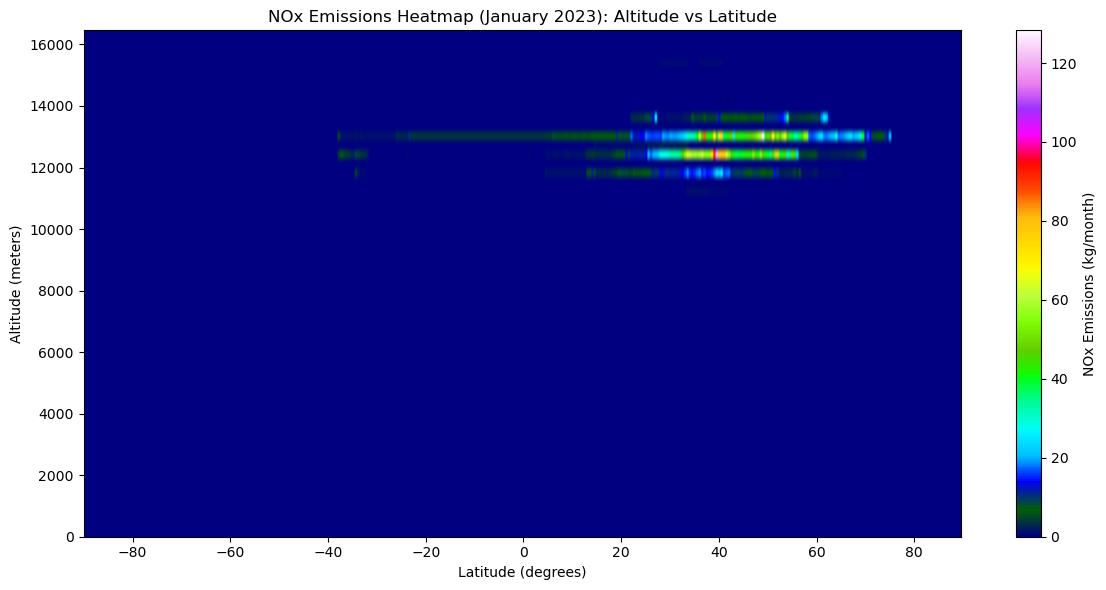

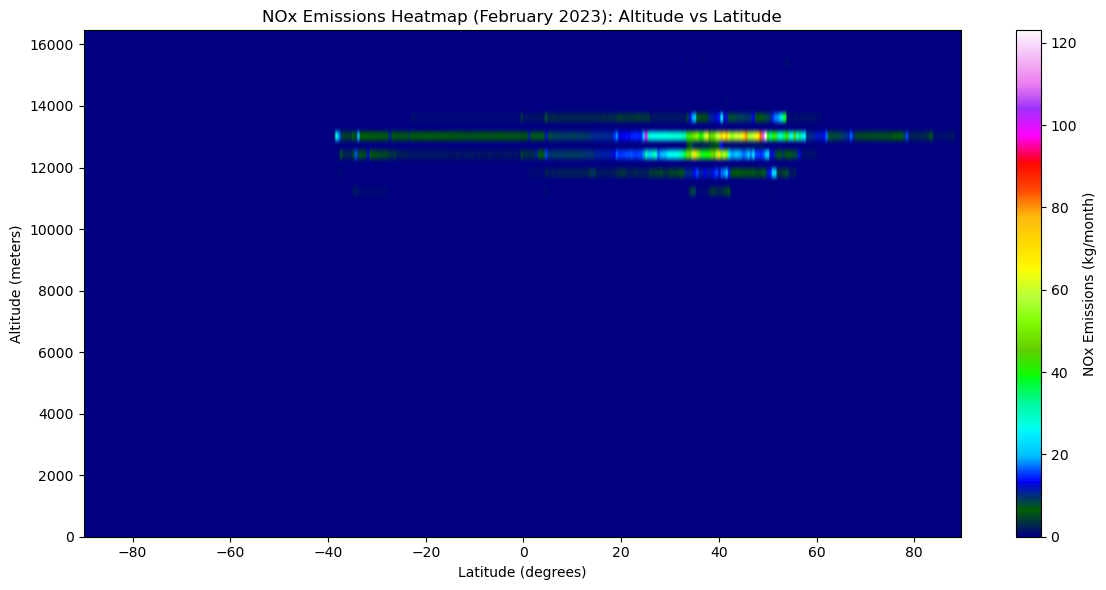

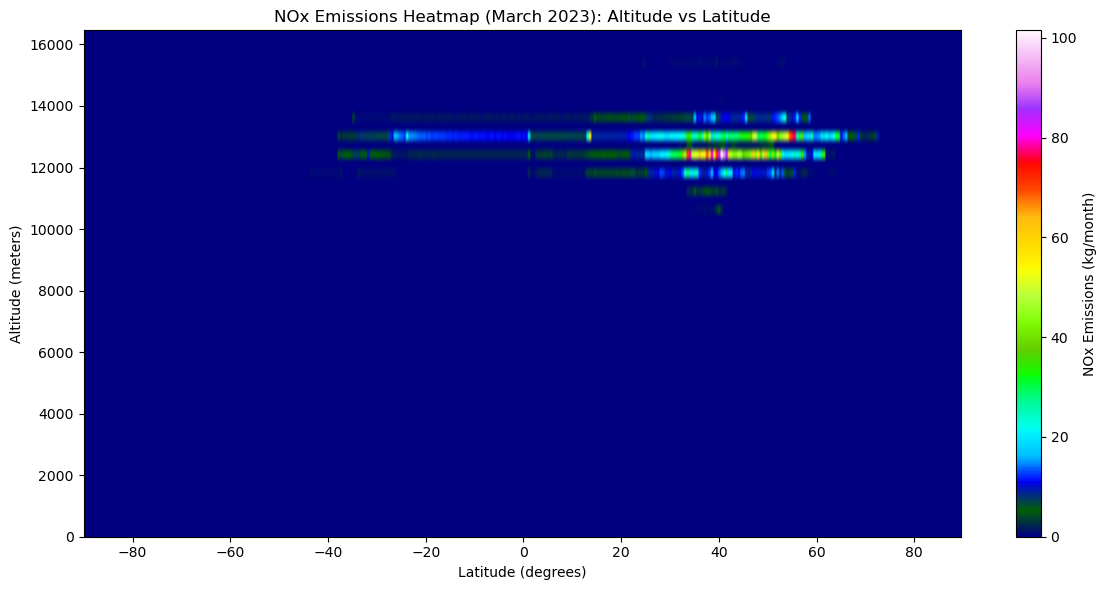

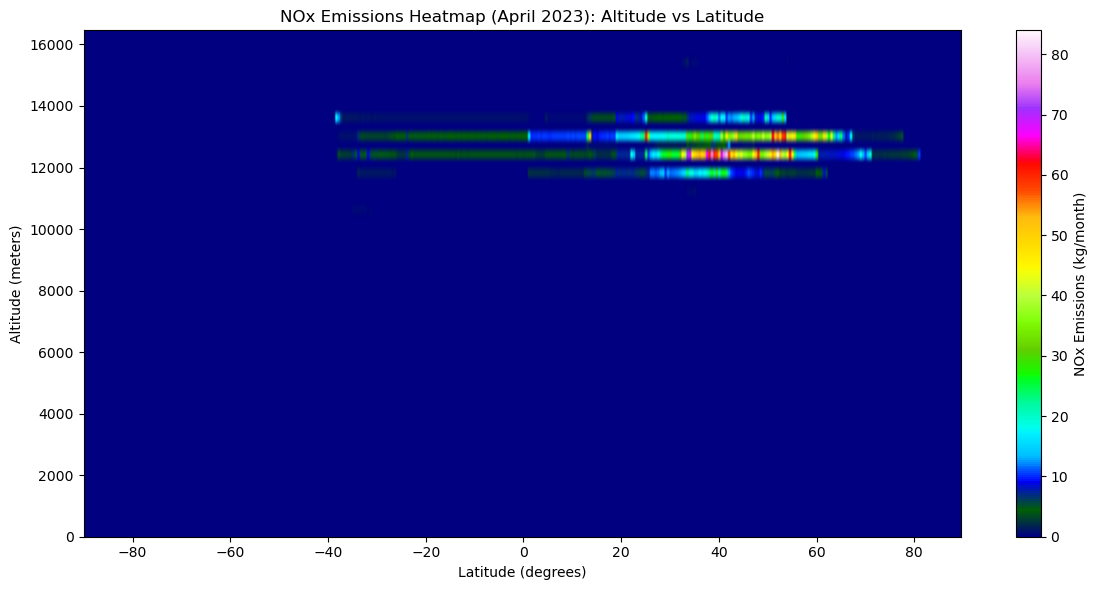

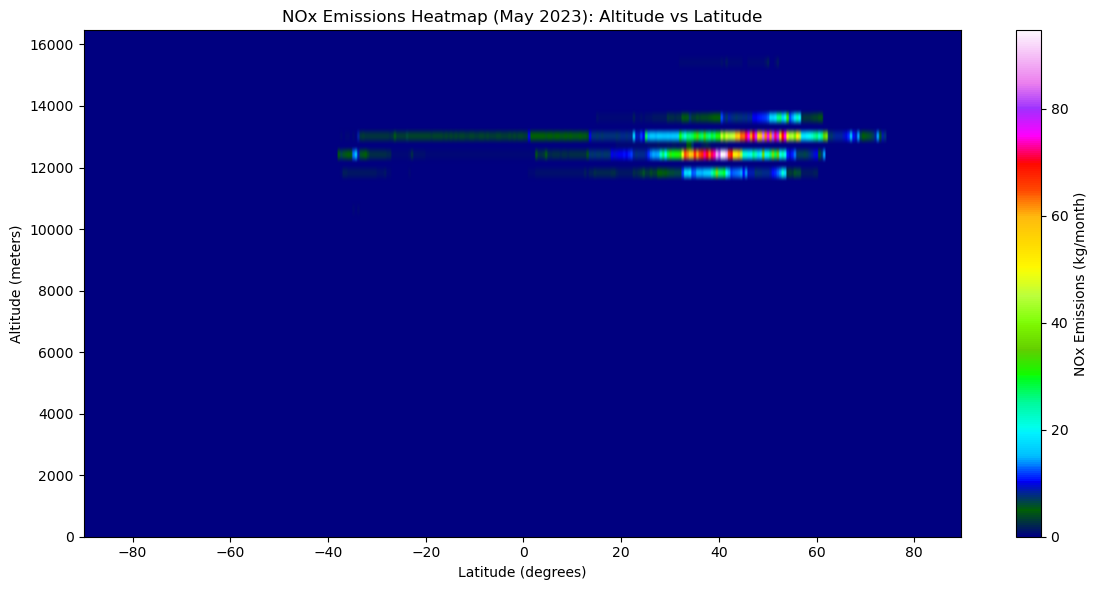

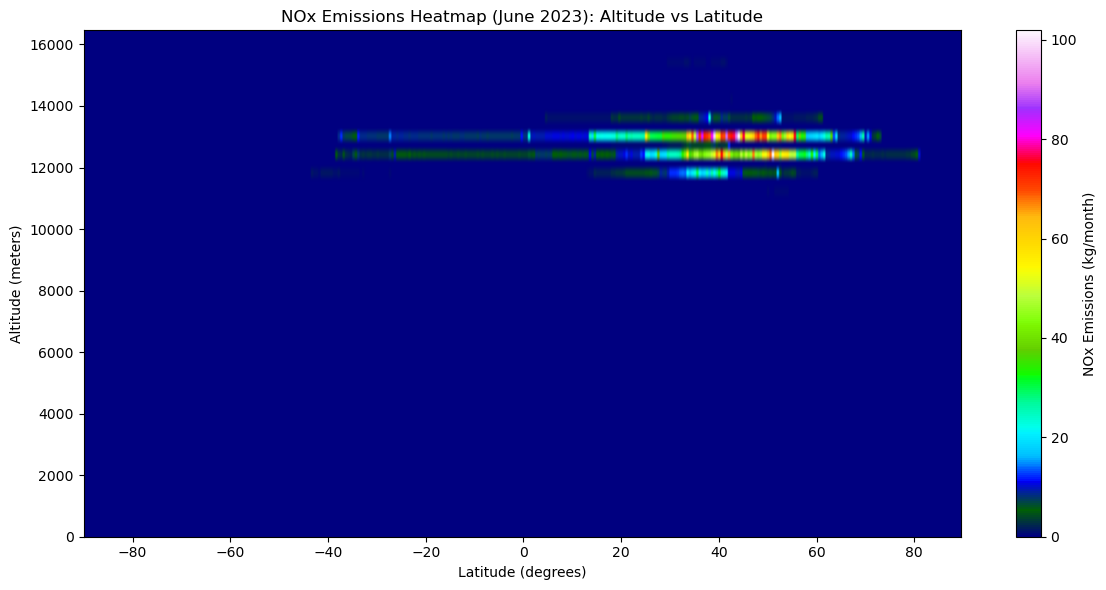

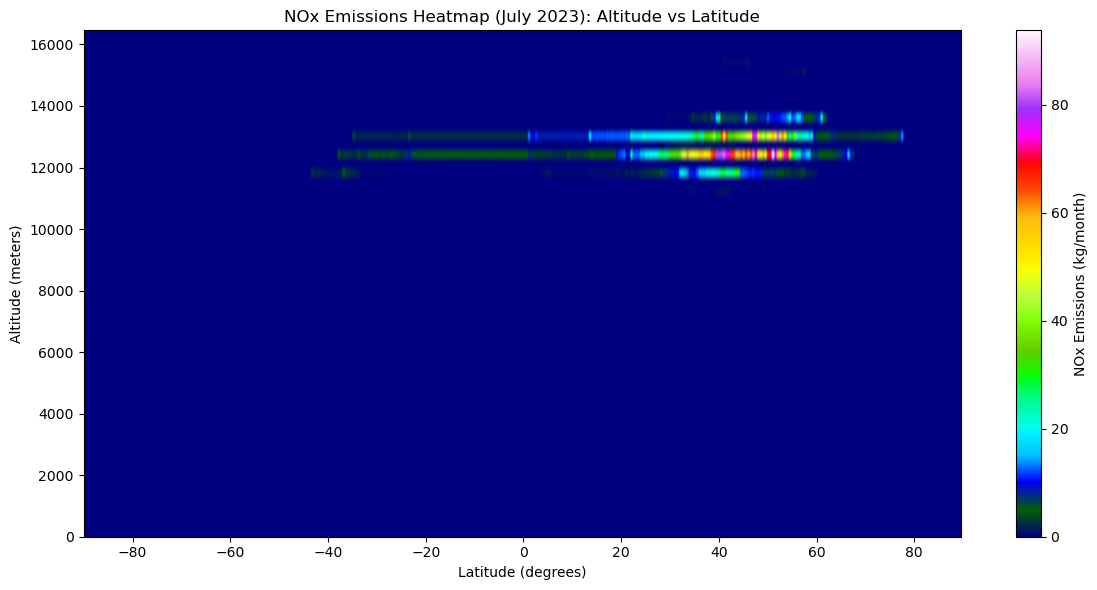

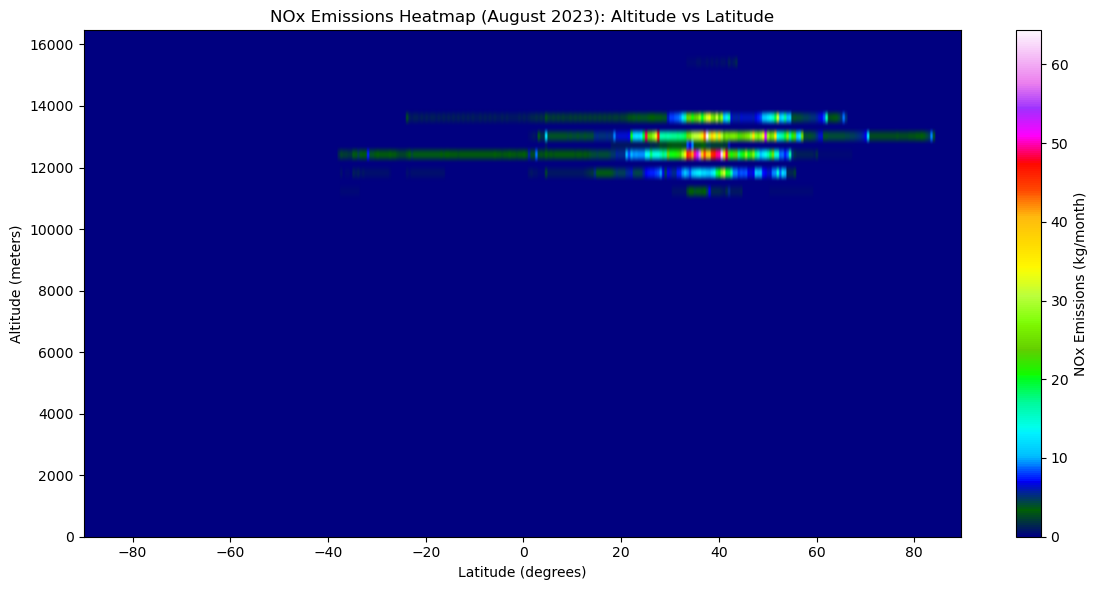

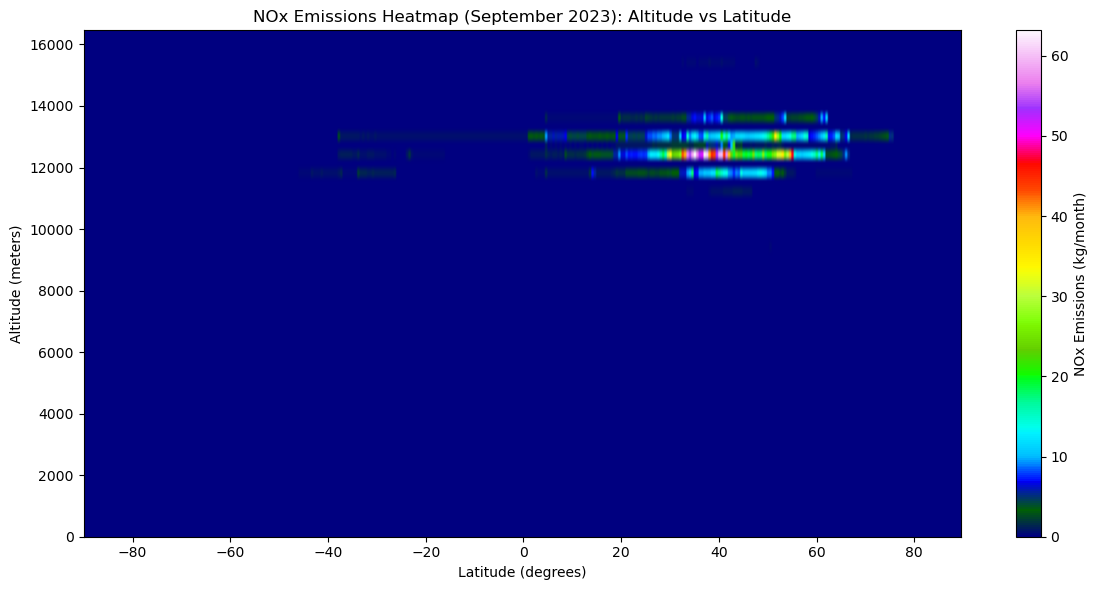

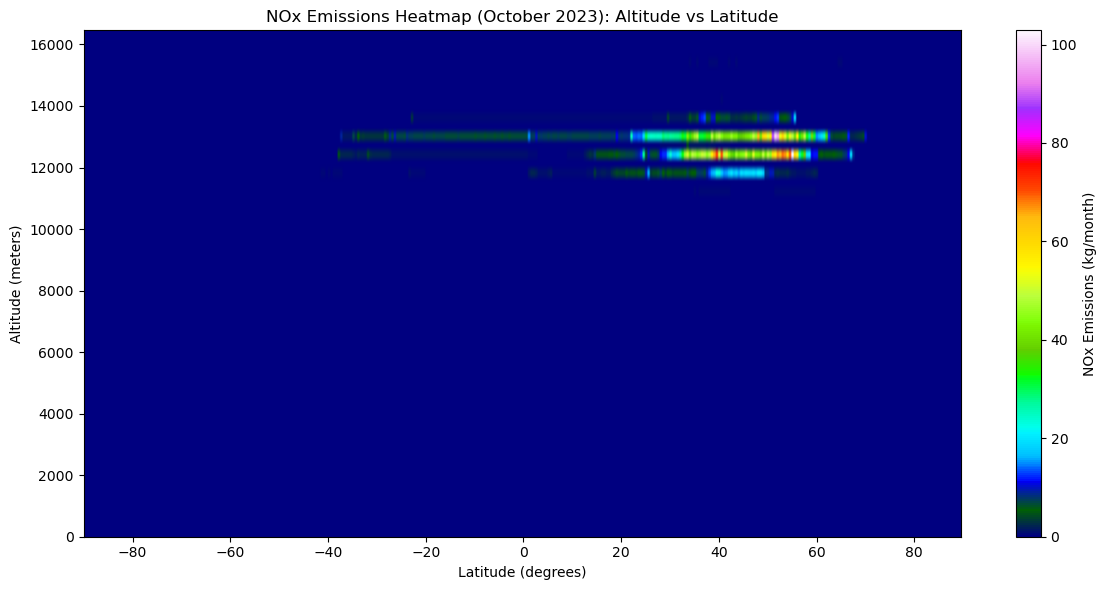

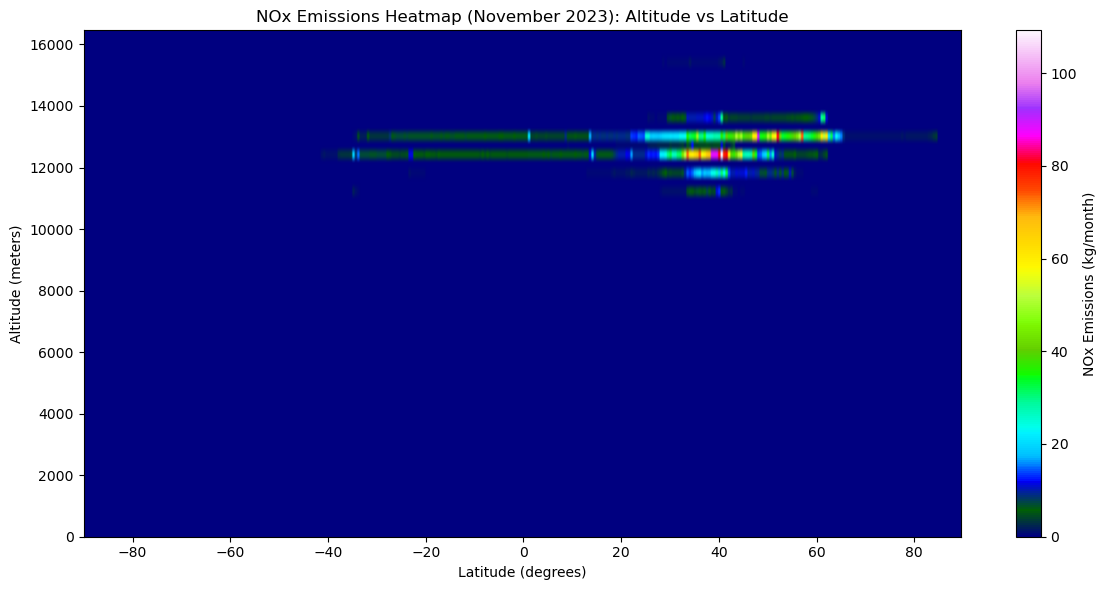

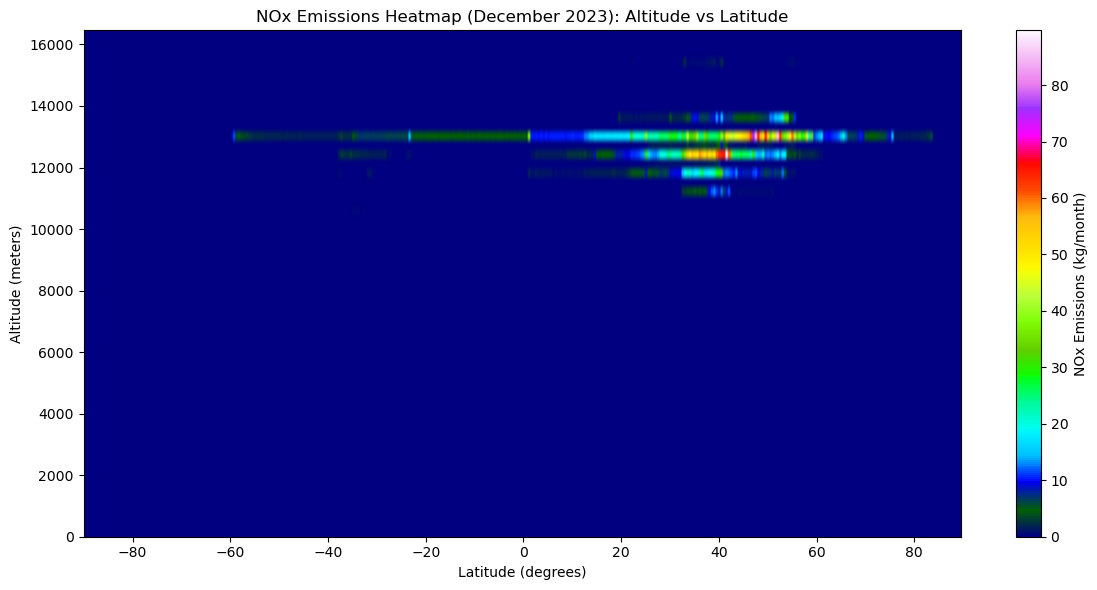

In [19]:
# make graphs of monthly NOx emissions by altitude and latitude
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")

    # Load the NOx emissions grid
    nox_grid = np.load(f'{output_dir}emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_nowar.npy')

    # Sum over longitude to get a 2D array: (latitude, altitude)
    nox_lat_alt = np.sum(nox_grid, axis=1)  # shape: (nlat, nalt)

    # Get month and year for the plot title
    month_year = pd.to_datetime(start_time_str_loop).strftime('%B %Y')

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    plt.imshow(
        nox_lat_alt.T, 
        aspect='auto', 
        origin='lower',
        extent=[lat_bins[0], lat_bins[-2], alt_bins_m[0], alt_bins_m[-2]],
        cmap='gist_ncar'
    )
    plt.colorbar(label='NOx Emissions (kg/month)')
    plt.xlabel('Latitude (degrees)')
    plt.ylabel('Altitude (meters)')
    plt.title(f'NOx Emissions Heatmap ({month_year}): Altitude vs Latitude')
    plt.tight_layout()
    plt.show()


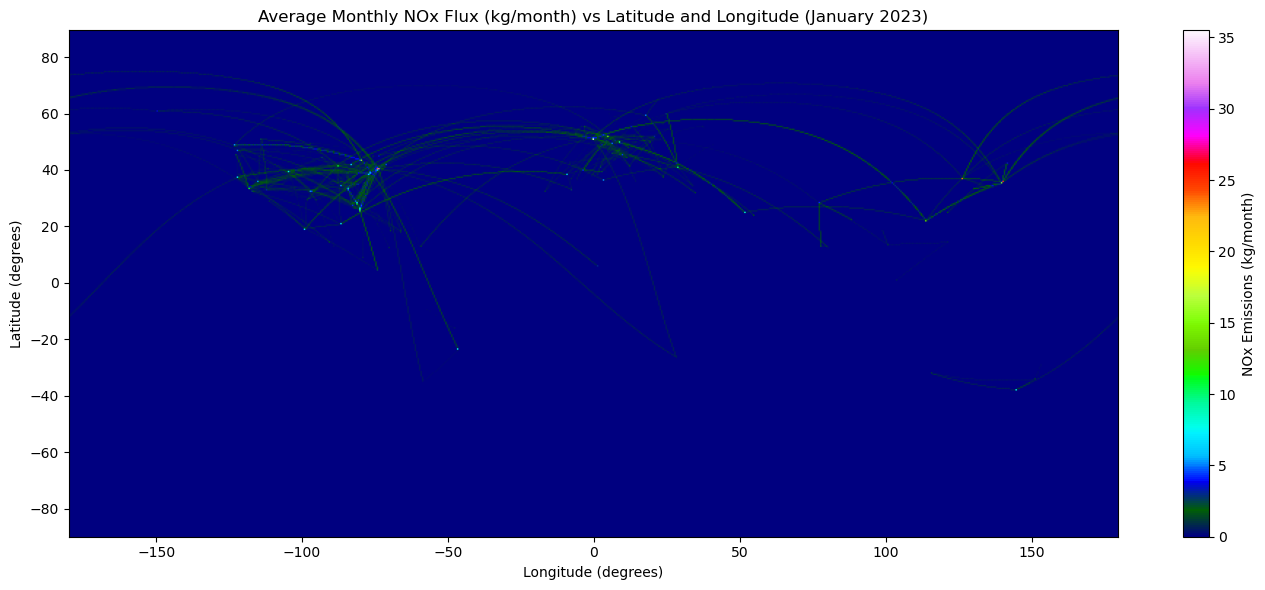

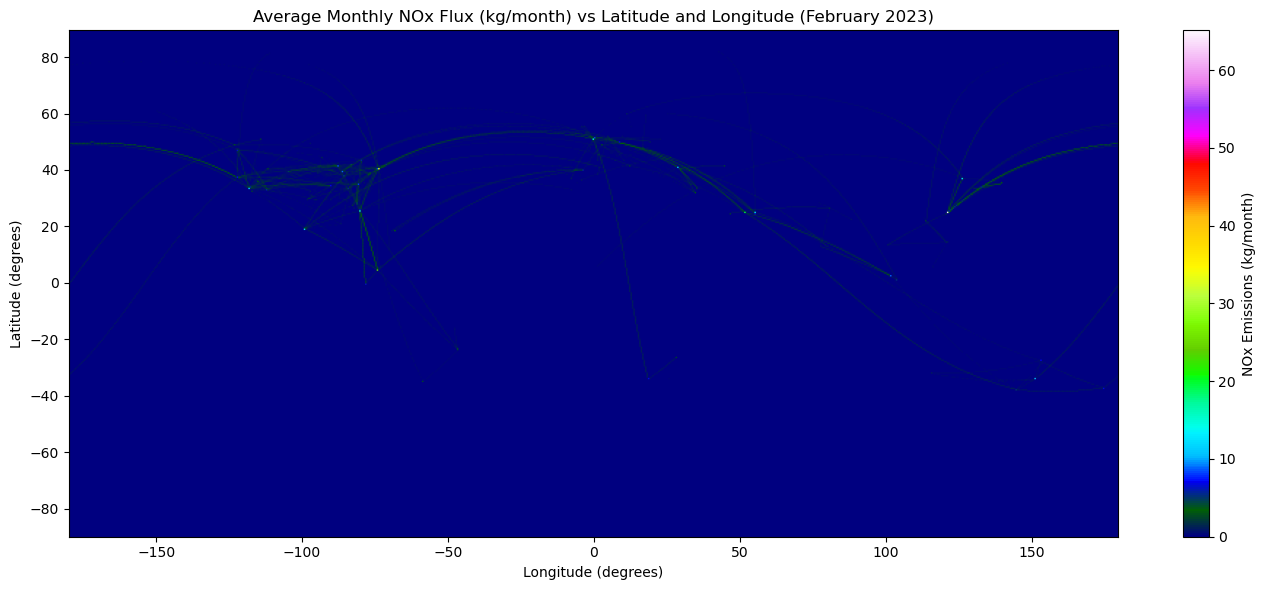

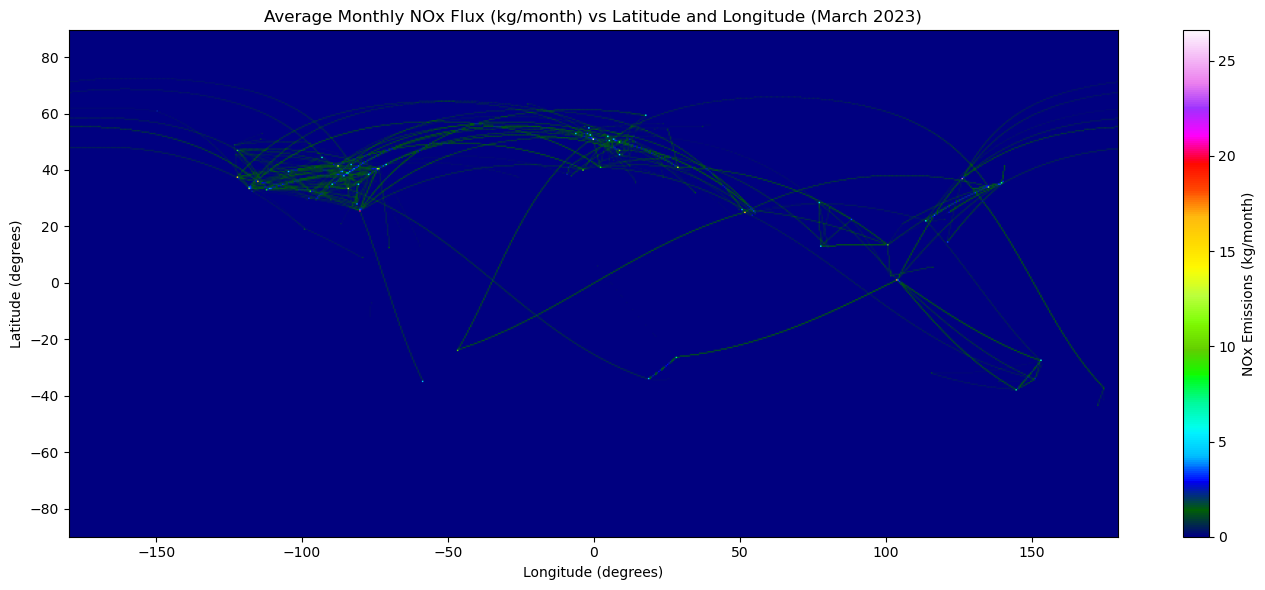

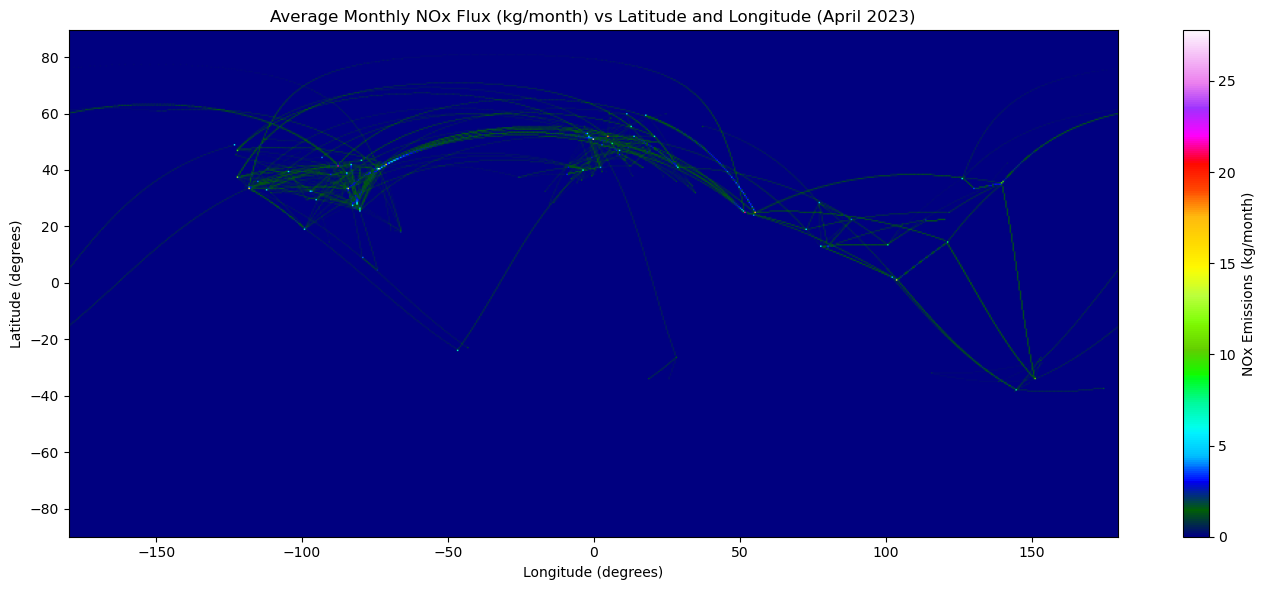

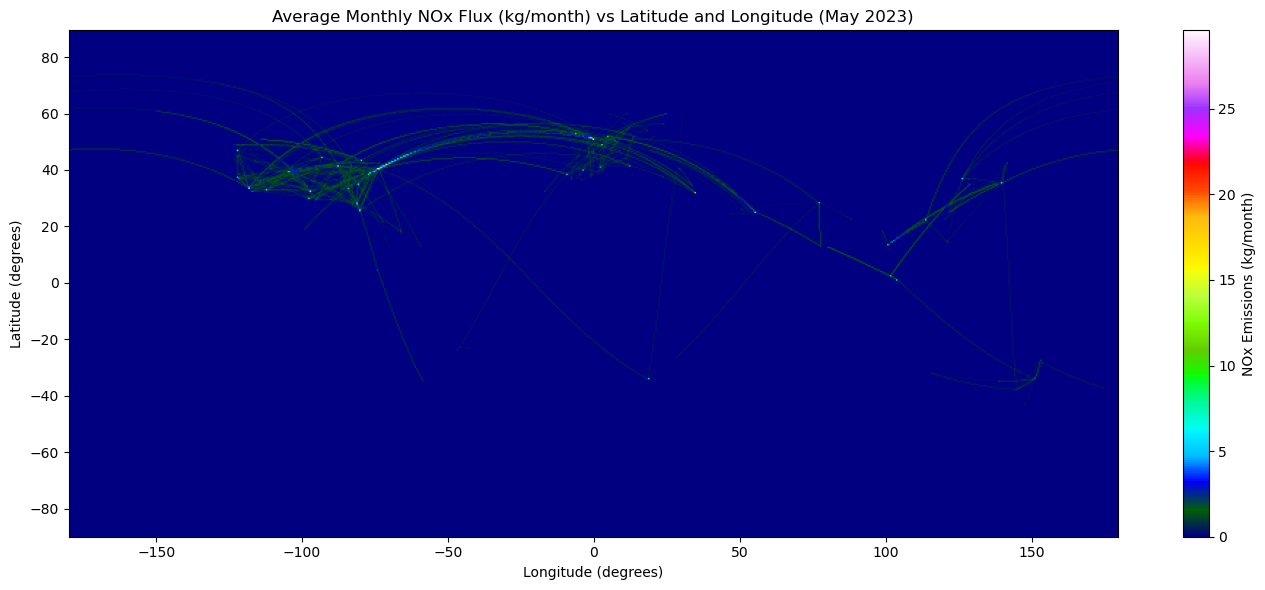

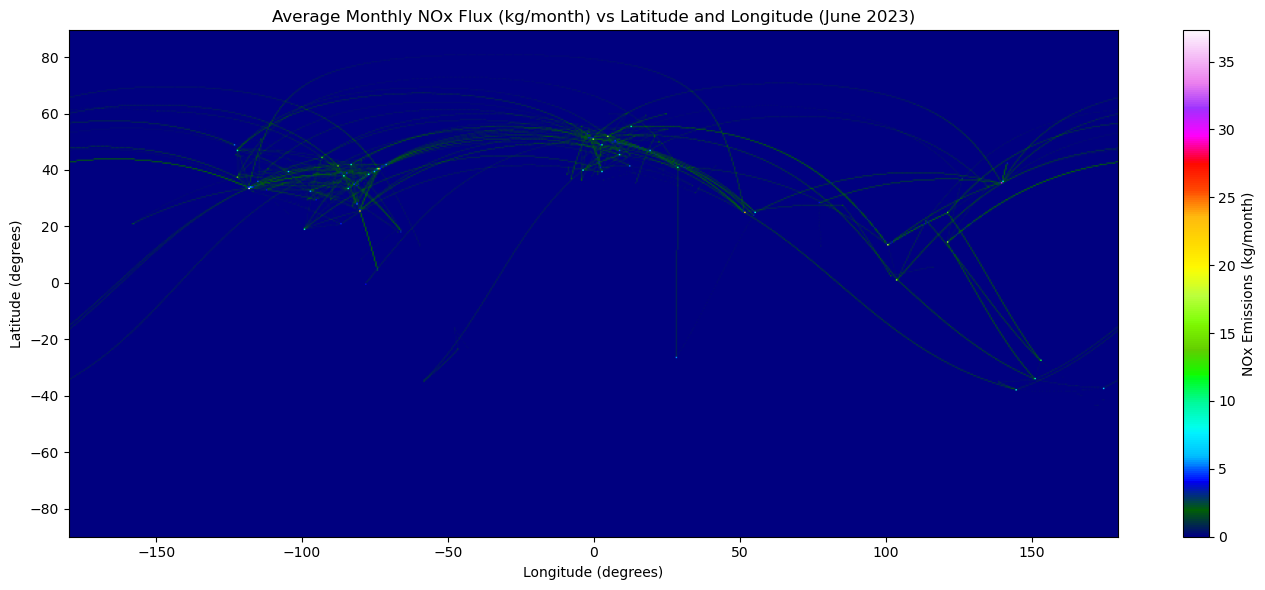

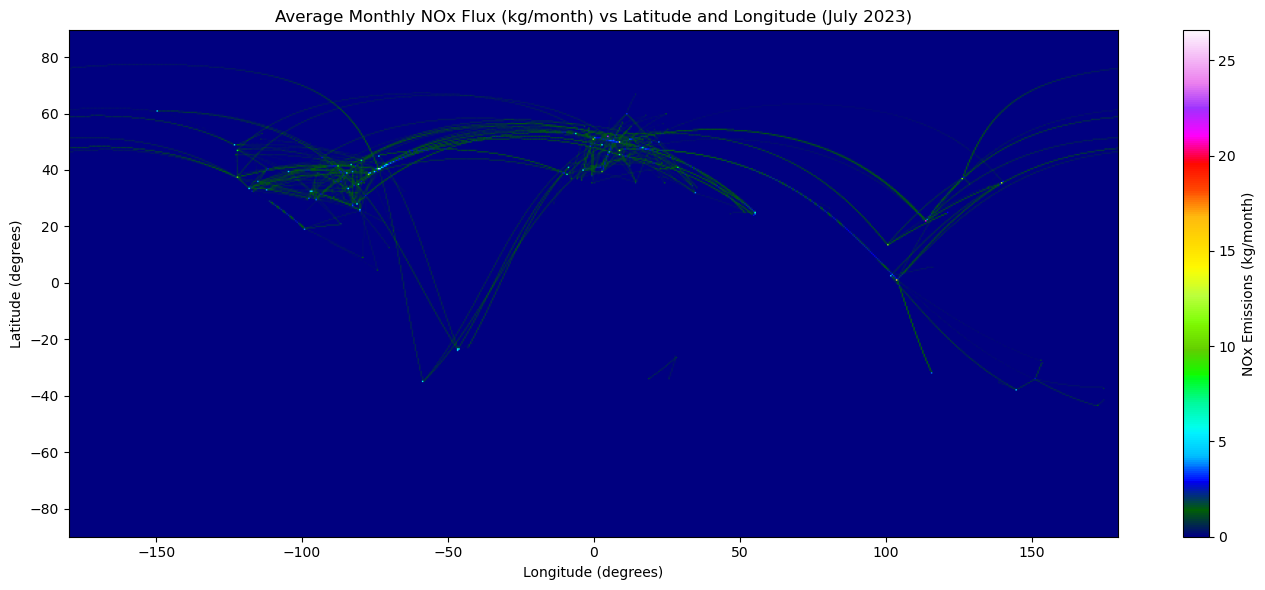

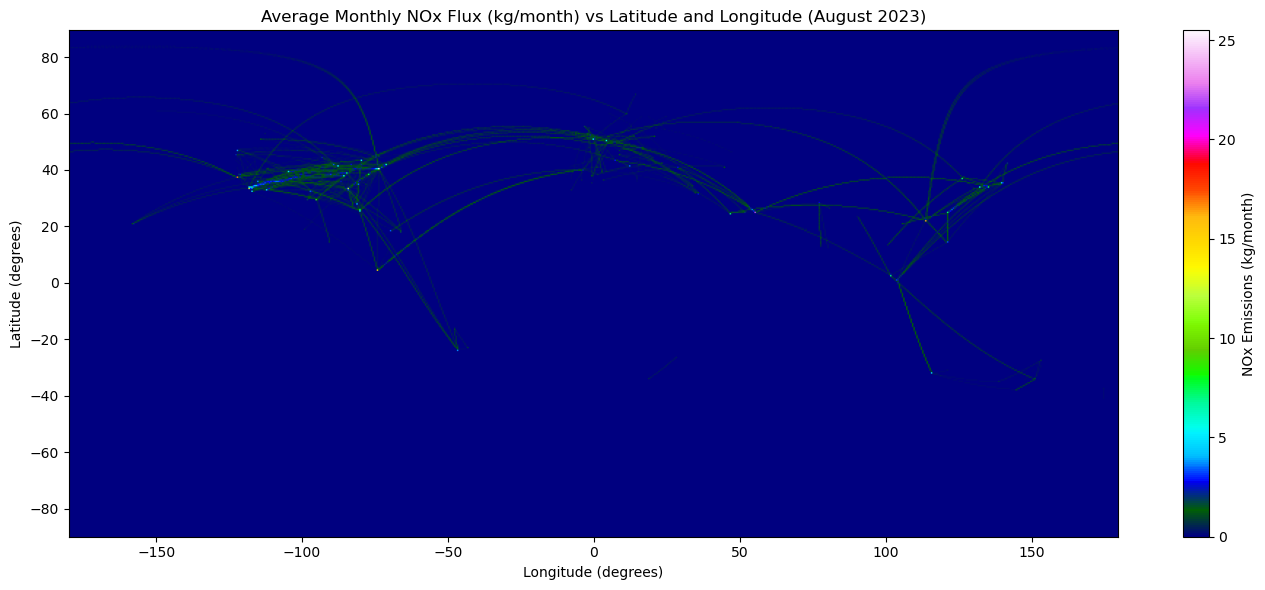

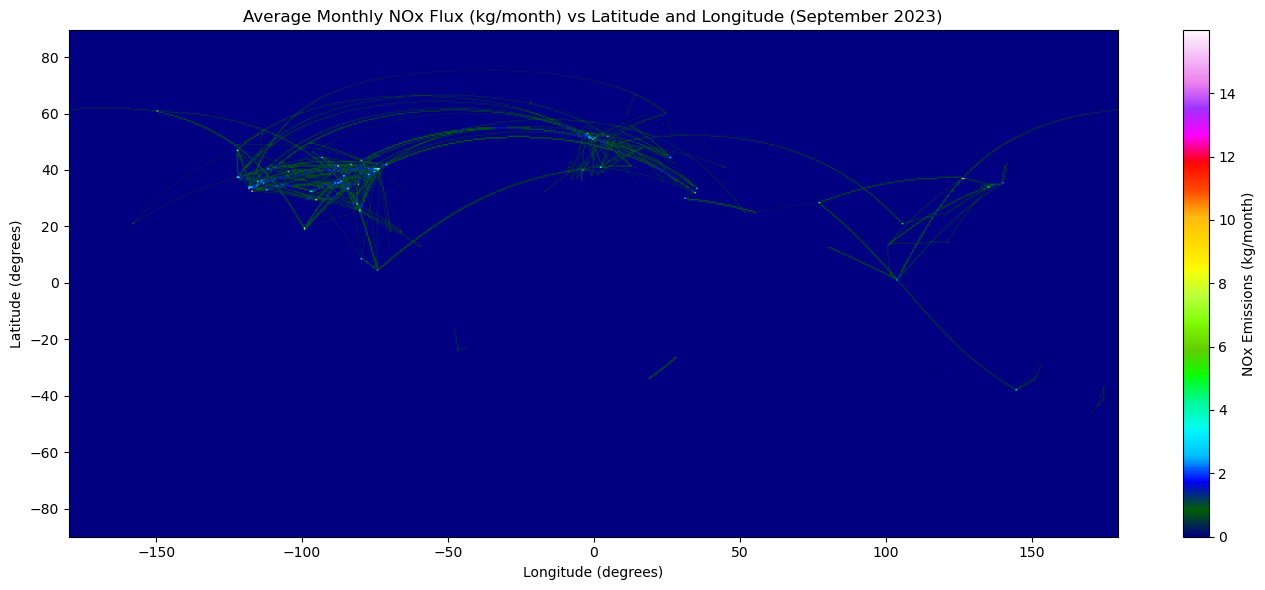

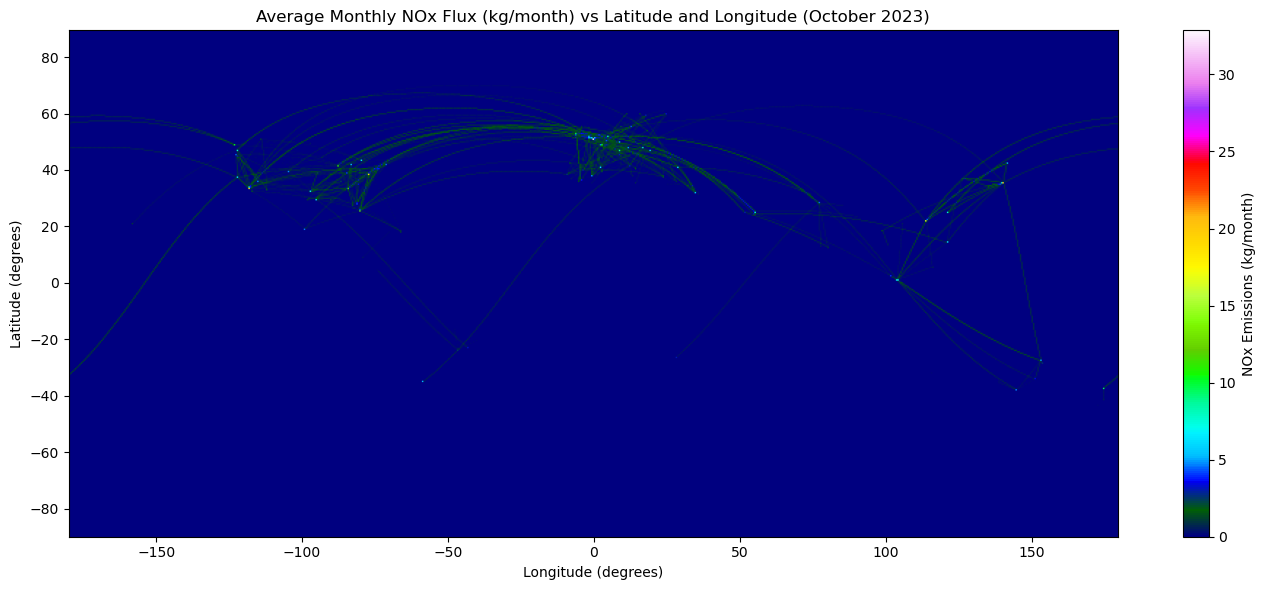

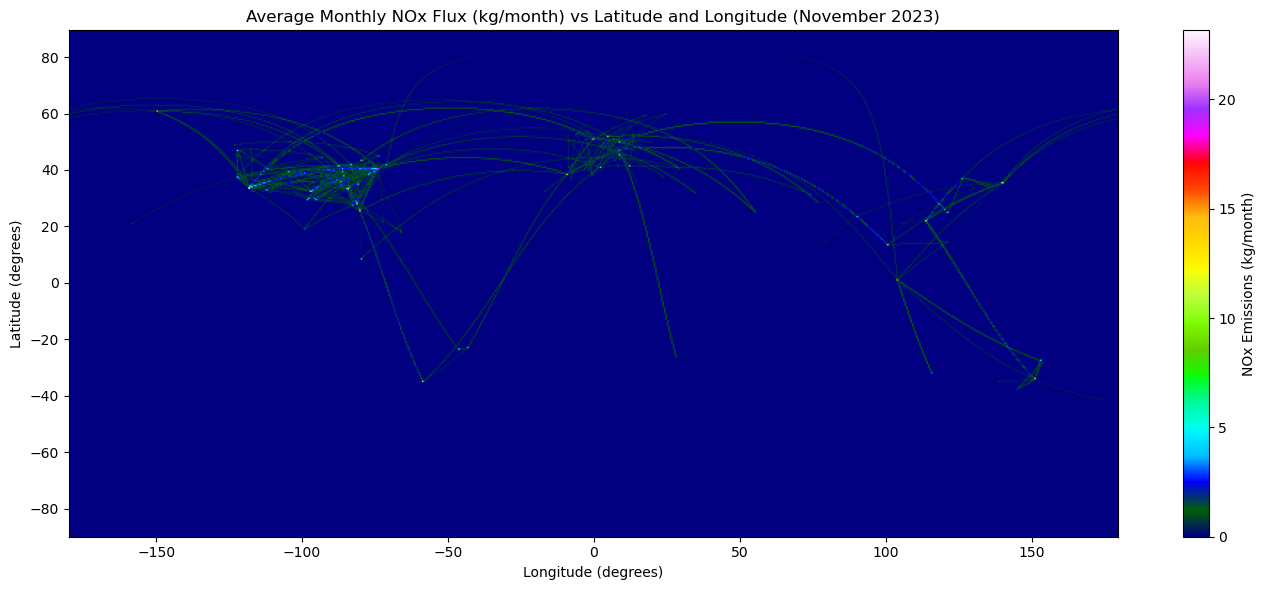

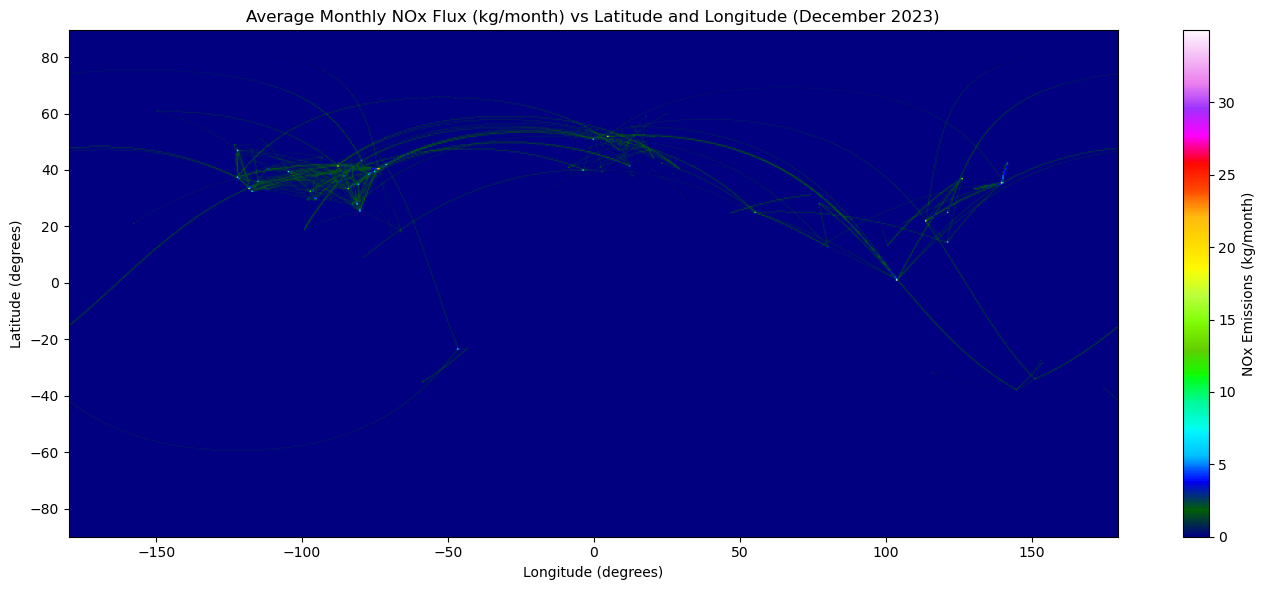

In [20]:
import matplotlib.pyplot as plt

# Loop over each month in the analysis period
for start_time_str_loop in pd.date_range(start=pd.to_datetime(start_time_str), end=pd.to_datetime(stop_time_str), freq='MS', tz='UTC'):
    stop_time_str_loop = (start_time_str_loop + pd.offsets.MonthEnd(1)).replace(hour=23, minute=59, second=59)
    start_time_simple_loop = pd.to_datetime(start_time_str_loop).strftime("%Y-%m-%d")
    stop_time_simple_loop = pd.to_datetime(stop_time_str_loop).strftime("%Y-%m-%d")
    month_year = pd.to_datetime(start_time_str_loop).strftime('%B %Y')

    # Load the NOx emissions grid for this month
    nox_grid = np.load(f'{output_dir}emissions/{start_time_simple_loop}_to_{stop_time_simple_loop}_NOx_nowar.npy')

    # Sum over altitude to get total NOx flux per (lat, lon) cell
    nox_lat_lon = np.sum(nox_grid, axis=2)

    plt.figure(figsize=(14, 6))
    plt.imshow(
        nox_lat_lon,
        extent=[lon_bins[0], lon_bins[-2], lat_bins[0], lat_bins[-2]],
        origin='lower',
        aspect='auto',
        cmap='gist_ncar'
    )
    plt.colorbar(label='NOx Emissions (kg/month)')
    plt.xlabel('Longitude (degrees)')
    plt.ylabel('Latitude (degrees)')
    plt.title(f'Average Monthly NOx Flux (kg/month) vs Latitude and Longitude ({month_year})')
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

# Helper to extract R^2 values from results dict
def extract_r2(results):
    return np.array([v['r2_mean'] for v in results.values() if 'r2_mean' in v and not np.isnan(v['r2_mean'])])

# Load the results dictionaries if not already in memory
import pickle
import os

model_dir = 'saved_models_nox_flux'

# Load the results dictionaries from pickle files
with open(os.path.join(model_dir, 'xgb_results.pkl'), 'rb') as f:
    xgb_results = pickle.load(f)
with open(os.path.join(model_dir, 'poly_results.pkl'), 'rb') as f:
    poly_results = pickle.load(f)
with open(os.path.join(model_dir, 'nl_results.pkl'), 'rb') as f:
    nl_results = pickle.load(f)

xgb_r2 = extract_r2(xgb_results)
ridge_r2 = extract_r2(poly_results)
nonlinear_r2 = extract_r2(nl_results)

print("XGBoost:   avg R^2 = {:.3f}, min R^2 = {:.3f}".format(np.mean(xgb_r2), np.min(xgb_r2)))
print("Ridge:     avg R^2 = {:.3f}, min R^2 = {:.3f}".format(np.mean(ridge_r2), np.min(ridge_r2)))
print("Nonlinear: avg R^2 = {:.3f}, min R^2 = {:.3f}".format(np.mean(nonlinear_r2), np.min(nonlinear_r2)))

### Output
- The file `nox_emissions_grid_jan2024.npy` contains a 3D numpy array of average NOx flux (kg/month) for each grid cell (lat, lon, alt) for January 2024.
- Each cell represents the average NOx present, accounting for a 2-day removal timescale.
- You can convert this to other formats (e.g., NetCDF) for visualization or further analysis.

In [ ]:
import pandas as pd
model = pd.read_pickle('saved_models_nox_flux/xgb_A320.pkl')